In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import exists
import json
import scipy.stats as stats
import math
import sklearn.linear_model as lm

import sys
sys.path.insert(0, "../util/")
import util as util

SyntaxError: unexpected EOF while parsing (util.py, line 69)

In [ ]:
fullDatingDatabase = pd.read_csv("../data/encoded-SpeedDatingData.csv")

In [ ]:
columnList = ["iid","gender","condtn","wave","round","order","pid","int_corr","age_o","race_o","pf_o_att","pf_o_sin","pf_o_int","pf_o_fun","pf_o_amb","pf_o_sha","dec_o","attr_o",
              "sinc_o","intel_o","amb_o","fun_o","shar_o","like_o","prob_o","age","field_cd","undergra","mn_sat","tuition","race","imprace","imprelig","from","zipcode",
              "income","goal","date","go_out","career_c","sports","tvsports","exercise","dining","museums","art","hiking","gaming","clubbing","reading","tv","theater",
              "movies","concerts","music","shopping","yoga","exphappy","expnum","attr1_1","sinc1_1","intel1_1","fun1_1","shar1_1","attr4_1","sinc4_1","intel4_1","fun4_1","shar4_1",
              "attr2_1","sinc2_1","intel2_1","fun2_1","shar2_1","attr3_1","sinc3_1","intel3_1","fun3_1","attr5_1","sinc5_1","intel5_1","fun5_1","dec","attr",
              "sinc","intel","fun","amb","like","prob","met","match_es","attr1_s","sinc1_s","intel1_s","fun1_s","shar1_s","attr3_s","sinc3_s","intel3_s","fun3_s"]
nonBinaryCategoricalList = ["condtn","race_o","wave","field_cd","undergra","race","from","zipcode","goal","date","go_out","career_c"]
stringToFloatList = ["tuition","mn_sat","income"]
partnerList = ["condtn","field_cd","undergra","mn_sat","tuition","race","imprace","imprelig","from",
               "zipcode","income","goal","date","go_out","career_c","sports","tvsports","exercise","dining","museums","art","hiking","gaming","clubbing","reading","tv",
               "theater","movies","concerts","music","shopping","yoga","exphappy","expnum","attr4_1","sinc4_1","intel4_1","fun4_1",
               "shar4_1","attr2_1","sinc2_1","intel2_1","fun2_1","shar2_1","attr3_1","sinc3_1","intel3_1","fun3_1","attr5_1","sinc5_1","intel5_1","fun5_1","match_es","attr1_s",
               "sinc1_s","intel1_s","fun1_s","shar1_s","attr3_s","sinc3_s","intel3_s","fun3_s"]
pointDistributionList = []

In [ ]:
blindDateData = fullDatingDatabase[columnList]
for catCol in nonBinaryCategoricalList:
    blindDateData[catCol] = blindDateData[catCol].apply(str)
    blindDateData[catCol] = blindDateData[catCol].fillna('nan')
for stringToFloatCol in stringToFloatList:
    blindDateData[stringToFloatCol] = blindDateData[stringToFloatCol].str.replace(',', '').astype(float)

In [ ]:
blindDateDataWave69 = blindDateData[(blindDateData['wave'].astype(int) >= 6) & (blindDateData['wave'].astype(int) <= 9)]
blindDateDataWaveNot69 = blindDateData[(blindDateData['wave'].astype(int) < 6) | (blindDateData['wave'].astype(int) > 9)]

In [ ]:
total = blindDateData.shape[0]
for col in columnList:
    colData = blindDateData[col]
    colData69 = blindDateDataWave69[col]
    colDataNot69 = blindDateDataWaveNot69[col]
    
    print(f'{col} {colData.dtype}')
    nanCount = sum([util.isNan(x) for x in colData])
    print(f'{100 * nanCount/total}% of data is nan. {nanCount} out of {total}')
    dataList = list(set(colData))
        
    if len(dataList)<=20:
        print(dataList)
    elif str(col) == 'met':
        print(colData.value_counts())
    else:
        if colData.dtype == "O":
            print(f"data varries across {len(dataList)} values")
        elif (col.endswith("1_1") or col.endswith("4_1") or col.endswith("2_1")):
            question = col[-3:]
            if question not in pointDistributionList:
                pointDistributionList.append(question)
            print(f"{colData69.mean()} +/- {colData69.std()}")
            fig = plt.figure()
            plt.hist(colData69)
            plt.title('Waves 6 - 9')
            plt.show()
            print(f"{colDataNot69.mean()} +/- {colDataNot69.std()}")
            fig = plt.figure()
            plt.hist(colDataNot69)
            plt.title('Excluding Waves 6 - 9')
            plt.show()
        else:
            print(f"{colData.mean()} +/- {colData.std()}")
            fig = plt.figure()
            plt.hist(colData)
            plt.show()
    print("\n")

In [7]:
columnDataDictionary = {"columnList": columnList,
                        "nonBinaryCategoricalList": nonBinaryCategoricalList,
                        "stringToFloatList": stringToFloatList,
                        "pointDistributionList": pointDistributionList,
                        "partnerList": partnerList}

with open('../data/columnDataDictionary.json', 'w') as fp:
        json.dump(columnDataDictionary, fp)

In [8]:
interestColumns = ["sports","tvsports","exercise","dining","museums","art","hiking","gaming","clubbing","reading","tv","theater","movies","concerts","music","shopping","yoga"]
gender0 = blindDateData[blindDateData['gender'] == 0]
gender1 = blindDateData[blindDateData['gender'] == 1]

In [9]:
selectedIndecies = np.random.choice(gender0.shape[0],replace = False,size = (40))

In [10]:
recordedCorr = []
pearsonCorr = []
spearmanCorr = []
for i in selectedIndecies:
    candidate = gender0.iloc[[i]]
    partner = gender1[(gender1['iid'] == float(candidate['pid'])) & (gender1['pid'] == float(candidate['iid']))]
    candidateInterests = []
    partnerInterests = []
    for col in interestColumns:
        candidateScore = float(candidate[col])
        partnerScore = float(partner[col])
        if (util.isNan(candidateScore) == False and util.isNan(partnerScore) == False):
            candidateInterests.append(candidateScore)
            partnerInterests.append(partnerScore)
    if len(candidateInterests) >= 2:
        recordedCorr.append(candidate['int_corr'])
        pearsonValue = stats.pearsonr(np.array(candidateInterests),np.array(partnerInterests))[0]
        spearmanValue = stats.spearmanr(np.array(candidateInterests),np.array(partnerInterests))[0]
        pearsonCorr.append(pearsonValue)
        spearmanCorr.append(spearmanValue)

pearsonError = np.mean((np.array(pearsonCorr) - np.array(recordedCorr))/np.array(recordedCorr))
spearmanError = np.mean((np.array(spearmanCorr) - np.array(recordedCorr))/np.array(recordedCorr))
print(f'Pearson Error {pearsonError}')
print(f'Spearman Error {spearmanError}')

Pearson Error 0.19545800493832252
Spearman Error 0.09076741003493165


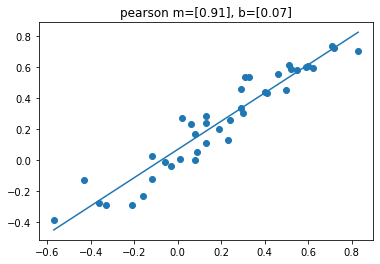

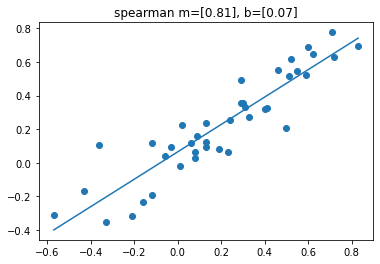

In [11]:
recordedArray = np.array(recordedCorr).reshape(-1,1)
pearsonArray = np.array(pearsonCorr).reshape(-1,1)
spearmanArray = np.array(spearmanCorr).reshape(-1,1)

util.plotCorrelation(recordedArray,pearsonArray,'pearson')
util.plotCorrelation(recordedArray,spearmanArray,'spearman')